In [1]:
# Needed for memory usage profiling
%load_ext memory_profiler
# Needed for runtime profiling
%load_ext line_profiler
# Needed for static or interactive matplotlib plots
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d
from scipy.sparse import bsr_matrix, diags, dia_matrix, csr_matrix

from skimage import data, io, color
from skimage.transform import resize

from array import array

plt.rcParams['figure.figsize'] = [10, 10]

def show_image(image, title):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def show_sparse_image(image, title):
    plt.spy(image)
    plt.title(title)
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def linear_to_row_col(index, row_width):
    return (index // row_width, index % row_width)

##### Decimation matrix (row major) - assumes only taking 4 neighbours and that $L = M*2$

In [2]:
# l = 4
# m = 2
# d = l // m

# d_matrix = np.zeros((m**2, l**2))

# tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
# t_len = tile.shape[0]

# for p in np.arange(l//4):
#     p_offset = p * l # 8
#     for q in np.arange(m):
#         d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
#         r_offset = m**2 // 2
#         c_offset = l**2 // 2
#         d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
        
# print(d_matrix)

In [3]:
# x = np.arange(1, 65) # 1..64
# print(x.reshape(8, 8))

# y = np.matmul(d_matrix * 1/4, x)
# print(y.reshape(4, 4))

##### Decimation matrix - downsample matrix $l^2$ by integer factor $n$ (assumes $n$ is suitable factor of $l$ shape)

In [4]:
# def decimation_matrix(original_dim, downsample_factor):
    
#     if original_dim % downsample_factor != 0:
#         raise ValueError(f"Downsample factor {downsample_factor} is not a valid factor of your matrix dimension {original_dim}.")
#     if downsample_factor == original_dim:
#         raise ValueError(f"Downsample factor {downsample_factor} cannot be the same as your matrix dimension {original_dim}.")
#     if downsample_factor == 1: # effectively, no downsampling
#         return np.identity(original_dim**2)
#     # Otherwise assumed you want to downsample by a valid factor of original_dim...
    
#     sampling_regions_per_dim = original_dim // downsample_factor
#     samples_per_region_dim = downsample_factor
#     # print(f"Sampling regions per dimension: {sampling_regions_per_dim}")
#     deci = np.zeros((sampling_regions_per_dim**2, original_dim**2))
#     # print(deci.shape)
    
#     # Generates linear x,y index strides for downsampling
#     sample_stride_1D = np.arange(0, original_dim, downsample_factor)
#     # print(sample_stride_1D)
#     mesh = np.array(np.meshgrid(sample_stride_1D, sample_stride_1D))
#     sample_strides_2D = mesh.T.reshape(-1, 2)
#     # print(sample_strides_2D)
  
#     neighbour_strides_1D = np.arange(samples_per_region_dim)
#     neighbour_mesh = np.array(np.meshgrid(neighbour_strides_1D, neighbour_strides_1D))

#     for index in np.arange(sample_strides_2D.shape[0]):
#         neighbour_coords = neighbour_mesh.T.reshape(-1, 2) + sample_strides_2D[index] # generates (row, col) index pair for the nxn neighbours of each sampling point in sample_strides_2D
#         neighbour_coords[:, 0] *= original_dim # scale y coord by high-resolution image dim to enable row striding (due to column-vector matrix flattening)
#         neighbour_coords = np.sum(neighbour_coords, axis=1) # combine x and y coord into single array index
#         deci[index, neighbour_coords] = 1.0
        
#     return deci
    
# # Testing of new decimation matrix routine
# l = np.arange(9**2)
# print(l.reshape(9, 9))
# d = decimation_matrix(9, 3)
# show_plot(d)
# m = d @ l
# print(m.shape)
# print(m.reshape(3, 3))

Decimation matrix using the [Block Sparse Row (BSR) matrix format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html#scipy-sparse-bsr-matrix)

In [5]:
# def decimation_matrix(original_dim, downsample_factor):
    
#     if original_dim % downsample_factor != 0:
#         raise ValueError(f"Downsample factor {downsample_factor} is not a valid factor of your matrix dimension {original_dim}.")
#     if downsample_factor == original_dim:
#         raise ValueError(f"Downsample factor {downsample_factor} cannot be the same as your matrix dimension {original_dim}.")
#     if downsample_factor == 1: # effectively, no downsampling
#         return np.identity(original_dim**2)
#     # Otherwise assumed you want to downsample by a valid factor of original_dim...
    
#     sampling_regions_per_dim = original_dim // downsample_factor
#     samples_per_region_dim = downsample_factor
#     # print(f"Sampling regions per dimension: {sampling_regions_per_dim}")
#     # print(f"Samples per dimension: {samples_per_region_dim}")
#     non_zero_entries = sampling_regions_per_dim**2 * samples_per_region_dim**2
#     # print(f"Non-zero entries: {non_zero_entries}")
    
#     rows = np.zeros(non_zero_entries, dtype=np.uintc)   # stores row indices for non-zero compressed sparse matrix entries
#     cols = np.zeros(non_zero_entries, dtype=np.uintc)   # stores col indices for non-zero compressed sparse matrix entries
#     vals = np.ones(non_zero_entries, dtype=np.float32)  # stores element value at [row, col] for non-zero entries
    
#     # Generates linear x,y index strides for downsampling
#     sample_stride_1D = np.arange(0, original_dim, downsample_factor)
#     # print(sample_stride_1D)
#     mesh = np.array(np.meshgrid(sample_stride_1D, sample_stride_1D))
#     sample_strides_2D = mesh.T.reshape(-1, 2)
  
#     neighbour_strides_1D = np.arange(samples_per_region_dim)
#     neighbour_mesh = np.array(np.meshgrid(neighbour_strides_1D, neighbour_strides_1D))

#     for index in np.arange(sample_strides_2D.shape[0]):
#         neighbour_coords = neighbour_mesh.T.reshape(-1, 2) + sample_strides_2D[index] # generates (row, col) index pair for the nxn neighbours of each sampling point in sample_strides_2D
#         neighbour_coords[:, 0] *= original_dim # scale y coord by high-resolution image dim to enable row striding (due to column-vector matrix flattening)
#         neighbour_coords = np.sum(neighbour_coords, axis=1) # combine x and y coord into single array index
#         rows[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = index
#         cols[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = neighbour_coords
        
#     return bsr_matrix((vals, (rows, cols)))
    
# # Testing of new decimation matrix routine
# l_dim = 8
# deci_factor = 4

# l = np.arange(l_dim**2)
# print(l.reshape(l_dim, l_dim))
# d = decimation_matrix(l_dim, deci_factor)
# print(type(d))
# print((d.data.nbytes + d.indptr.nbytes + d.indices.nbytes) / 10**6)
# # print(d)
# # show_image(d, "D")
# m = d @ l
# print(m.shape)
# print(m.reshape(l_dim//deci_factor, l_dim//deci_factor))

##### Sharpening matrix (padded)

In [6]:
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (100, 100), anti_aliasing=True)
# show_plot(x)

# laplace_deblur = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# scikit_convolved = normalise(convolve2d(x, laplace_deblur, mode="same"))
# show_plot(scikit_convolved)

# l = x.shape[0]
# laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)
# laplacian_dim = laplacian.shape[0]
# padding = laplacian_dim - 1 # s_matrix padding for out of bounds convolution
# laplacian = laplacian.flatten()
# strided_laplacian = np.insert(laplacian, laplacian_dim, np.repeat(0, l-1))
# strided_laplacian = np.insert(strided_laplacian, laplacian_dim*2+l-1, np.repeat(0, l-1))
# s_matrix = np.zeros(((l+padding)**2, (l+padding)**2), dtype=np.float32)

# for sr in np.arange(l):
#     for r in np.arange(l):
#         row_offset = (sr*l)+(l+padding+padding//2)+(padding*sr)
#         col_offset = sr*(l+padding)+r
#         s_matrix[row_offset+r, col_offset:col_offset+strided_laplacian.shape[0]] = strided_laplacian

# show_plot(s_matrix)
        
# x_padded = np.pad(x, 1)
# x_padded = x_padded.reshape(1, x_padded.shape[0]**2)
# x_padded = np.matmul(s_matrix, x_padded.T)
# x_padded = x_padded.reshape(102, 102)[1:101, 1:101]
        
# show_plot(normalise(x_padded))
# show_plot(scikit_convolved - normalise(x_padded))

##### Convolution matrix (no padding, sharpening example) using the [Block Sparse Row (BSR) matrix format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html#scipy-sparse-bsr-matrix)
##### (Note: only works for small samples... it is too much of a memory hog...)

In [7]:
# def convolution_matrix(l, kernel):
#     conv = np.zeros((l**2, l**2), dtype=np.float32)
#     full_supp = kernel.shape[0] # assumed square
#     half_supp = (full_supp - 1) // 2

#     for conv_row in np.arange(l**2):

#         row, col = (conv_row // l, conv_row % l)

#         for k_row in np.arange(-(half_supp), half_supp + 1):
#             # map "kernel row" to rows in conv
#             mapped_row = row + k_row
#             # ignore any out of bounds rows
#             if mapped_row >= 0 and mapped_row < l:
#                 linear_col = col - half_supp
#                 # truncate negative columns
#                 mapped_col_start = max(linear_col, 0)
#                 # truncate columns which exceed the l dimension
#                 mapped_col_end = min(linear_col + full_supp, l)
#                 # left trimming for kernels when overlapping out of bounds region in conv (col < 0)
#                 left = np.absolute(col - half_supp) if linear_col < 0 else 0
#                 # right trimming for kernels when overlapping out of bounds region in conv (col >= l)
#                 right = linear_col + full_supp - l if linear_col + full_supp >= l else 0 
#                 # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
#                 conv[conv_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = kernel[k_row + half_supp][left: left + full_supp - right]
#     return conv

# l = 300
# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (l, l), anti_aliasing=True)
# # show_image(x, "X")

# laplace = np.array([[1, -1,  1], [-1,  4, -1], [1, -1,  1]], dtype=np.float32)
# # laplace = np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]], dtype=np.float32) * 1/273
# full_supp = laplace.shape[0] # assumed square
# half_supp = (full_supp - 1) // 2
# kernel_samples = full_supp**2

# non_zero_entries = full_supp**2 * l**2
# # print(f"Total non-zero entries: {non_zero_entries}")
# rows = np.zeros(non_zero_entries, dtype=np.uintc)
# cols = np.zeros(non_zero_entries, dtype=np.intc)
# vals = np.zeros(non_zero_entries, dtype=np.float32)

# # for each flattened "convolution" row in matrix
# for m_row in np.arange(l**2):
    
#     # map flattened m_row to 2d row/col  
#     row, col = (m_row // l, m_row % l)
#     # print(f"M_row {m_row} maps to row/col {row}, {col}")
    
#     # map kernel to neighbouring indices of row/col, from centre of kernel
#     neighbour_rows =  np.arange(-(half_supp), half_supp+1) + row
#     neighbour_cols = np.arange(-(half_supp), half_supp+1) + col
#     mesh = np.array(np.meshgrid(neighbour_rows, neighbour_cols))
#     neighbour_indices = mesh.T.reshape(-1, 2)
    
#     # zero out in kernel, any neighbours which have negative index or greater than l
#     bad_rows = np.concatenate((np.where(neighbour_indices[:, 0] < 0)[0], np.where(neighbour_indices[:, 0] >= l)[0]))
#     bad_cols = np.concatenate((np.where(neighbour_indices[:, 1] < 0)[0], np.where(neighbour_indices[:, 1] >= l)[0]))
#     # get a set of distinct neighbours to be zeroed out (in case of duplicate entries where a bad row is also a bad column)
#     bad_neighbours = np.unique(np.concatenate((bad_rows, bad_cols)))
#     # print(bad_neighbours)
    
#     kernel = laplace.flatten()
#     kernel[bad_neighbours] = 0.0
    
#     start = m_row * full_supp**2
#     end = (m_row + 1) * full_supp**2
#     col_strides = np.repeat((np.arange(-half_supp, half_supp + 1)), (np.repeat(full_supp, full_supp))) * (l - full_supp)
#     # populating row indices and flattened kernel slices
#     rows[start:end] = m_row
#     cols[start:end] = (np.arange(m_row, m_row + full_supp**2) - full_supp**2 // 2 + col_strides)
#     vals[start:end] = kernel
    
# # strip away any entries in rows/cols/vals where cols < 0, cols >= l**2, or where val is zero
# out_of_bounds_or_zero = np.concatenate((np.where(cols < 0), np.where(cols >= l**2), np.where(vals == 0.0)), axis=None)
# rows = np.delete(rows, out_of_bounds_or_zero)
# cols = np.delete(cols, out_of_bounds_or_zero)
# vals = np.delete(vals, out_of_bounds_or_zero)

# # original_method = convolution_matrix(l, laplace.reshape(full_supp, full_supp))
# # # print((original_method.size * original_method.itemsize) / 10**6)
# # show_image(original_method, "Original Sharpening matrix")

# conv_matrix = bsr_matrix((vals, (rows, cols)))
# # print((conv_matrix.data.nbytes + conv_matrix.indptr.nbytes + conv_matrix.indices.nbytes) / 10**6)
# show_image(conv_matrix.todense(), "Sharpening matrix")

# scikit_convolved = normalise(convolve2d(x, laplace.reshape(full_supp, full_supp), mode="same"))
# show_image(scikit_convolved, "Scikit Convolved")

# x = x.reshape(1, x.shape[0]**2)
# x = conv_matrix.todense() @ x.T
# # # x = original_method @ x.T
# x = x.reshape(l, l)
        
# show_image(normalise(x), "Sharpened X")
# show_image(np.absolute(scikit_convolved - normalise(x)), "Abs Diff")

##### Convolution matrix (no padding, sharpening example) using a dictionary (for efficiency?) and the [Block Sparse Row (BSR) matrix format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html#scipy-sparse-bsr-matrix)
*The assumption is that I can maintain a top-level dictionary, where the key = the convolution kernel sample, and the value is a secondary dictionary, where the key-value pair is the row and column index of said kernel sample. From there, I should in theory be able to generate appropriately sized row/col/sample numpy arrays only containing valid entries in the convolution matrix, built using the CSR or BSR format...*

In [8]:
# %%file conv_matrix_sparse.py
# import numpy as np
# from scipy.sparse import bsr_matrix

# def convolution_matrix_sparse(l, kernel):
    
#     # Allocate a key-value pair for each distinct kernel sample (key) to an empty list (value) 
#     pixel_to_row_col_dict = {val : [] for val in np.unique(kernel)}
#     full_supp = kernel.shape[0] # assumed square
#     half_supp = (full_supp - 1) // 2
    
#     kernel = kernel.flatten()
#     neighbour_strides = np.arange(-(half_supp), half_supp+1)
    
#     for m_row in np.arange(l**2):
        
#         # map flattened m_row to 2d row/col  
#         row, col = (m_row // l, m_row % l)
#         # print(f"M_row {m_row} maps to row/col {row}, {col}")
        
#         neighbour_rows = neighbour_strides + row
#         neighbour_cols = neighbour_strides + col
        
#         # map kernel to neighbouring indices of row/col, from centre of kernel
#         meshgrid = np.meshgrid(neighbour_rows, neighbour_cols, copy=False)
#         mesh = np.array(meshgrid)
#         neighbour_indices = mesh.T.reshape(-1, 2)
        
#         # zero out in kernel, any neighbours which have negative index or greater than l
#         bad_rows = np.concatenate((np.where(neighbour_indices[:, 0] < 0)[0], np.where(neighbour_indices[:, 0] >= l)[0]))
#         bad_cols = np.concatenate((np.where(neighbour_indices[:, 1] < 0)[0], np.where(neighbour_indices[:, 1] >= l)[0]))
#         # get a set of distinct neighbours to be zeroed out (in case of duplicate entries where a bad row is also a bad column)
#         bad_neighbours = np.unique(np.concatenate((bad_rows, bad_cols)))
#         # print(f"Bad neighbours: {bad_neighbours}")

#         modified_kernel = np.copy(kernel)
#         # print(f"Original kernel: {modified_kernel}")
#         modified_kernel = np.delete(modified_kernel, bad_neighbours)
#         # print(f"Modified kernel: {modified_kernel}")
#         col_strides = np.repeat(neighbour_strides, (np.repeat(full_supp, full_supp))) * (l - full_supp)
#         # print(f"Col Strides: {col_strides}")
#         cols = np.delete((np.arange(m_row, m_row + full_supp**2) - full_supp**2 // 2 + col_strides), bad_neighbours)
        
#         # print(f"Column vals: {cols}")
#         for index, entry in enumerate(modified_kernel):
#             pixel_to_row_col_dict[entry].append((m_row, cols[index]))
        
#     entries = sum(len(v) for v in pixel_to_row_col_dict.values())
#     # print(entries)

#     row_col_pairs = np.zeros((entries, 2), dtype=np.uintc)
#     kernel_samples = np.zeros(entries, dtype=np.float32)
#     stride = 0
#     for k, v in pixel_to_row_col_dict.items():

#         if not v: # ignore pixels with no entries
#             continue

#         multiplier = len(v)
#         # print(multiplier)
#         kernel_samples[stride : stride + multiplier] = k
#         row_col_pairs[stride : stride + multiplier] = v
#         stride += multiplier
    
#     return bsr_matrix((kernel_samples, (row_col_pairs[:, 0], row_col_pairs[:, 1])), shape=(l**2, l**2))

In [9]:
# %%file conv_matrix_sparse.py

# from memory_profiler import profile
import numpy as np
from scipy.sparse import bsr_matrix, diags, dia_matrix, csr_matrix

# Steps to map a 2d convolution kernel to a "convolution" matrix. 
# Note: this disregards padding of the convolution at edges of the matrix to be "convolved" with. This is essentially a diagonal matrix, where the 2d kernel
#       is flattened, and each 1d "slice" is strided from one another by a separation of around "convolution" matrix width.
# Note: this method assumes we can build up a subset of the full matrix (lets call it a "submatrix"), and use simply arithmetic to
#       "slide" the submatrix diagonally to populate the full "convolution" matrix.
# Note: The format for storing this matrix is the Block Compressed Row sparse matrix format:
#       https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html

# @profile
def conv_matrix_sparse(l, kernel):
    supp = kernel.shape[0]
    half_supp = (supp - 1) // 2
    diagonal_strides = np.linspace(-half_supp, half_supp, supp, dtype=np.intc)

    submatrix_cols = np.zeros([], dtype=np.uintc)
    submatrix_rows = np.zeros([], dtype=np.uintc)
    submatrix_elements = np.zeros([], dtype=np.float32)

    for k in range(supp):
        # generate unpadded diagonal sparse matrix of kth kernel slice
        k_bsr = dia_matrix.tocsr(diags(kernel[k], diagonal_strides, shape=(l, l)))

        cols_for_rows = np.split(k_bsr.indices, k_bsr.indptr[1:-1]) # get col indices for entries in matrix
        rows_for_cols = np.repeat(np.arange(l), [len(arr) for arr in cols_for_rows])
        cols_for_rows = np.concatenate(cols_for_rows).ravel() + k * l # offset each diagonal

        # Ideally use of pre-allocated memory of known dimensions is ideal... but okay for now
        submatrix_cols = np.append(submatrix_cols, cols_for_rows)
        submatrix_rows = np.append(submatrix_rows, rows_for_cols)
        submatrix_elements = np.append(submatrix_elements, k_bsr.data)

    matrix_cols = np.zeros([], dtype=np.uintc)
    matrix_rows = np.zeros([], dtype=np.uintc)
    matrix_elements = np.zeros([], dtype=np.float32)

    # Now that we have the initial "submatrix" of diagonals, we can populate
    # the sparse matrix using strided, truncated submatrices
    for index, stride in enumerate(np.arange(-half_supp, -half_supp + l) * l):
        strided_cols = submatrix_cols + stride
        in_range_cols = np.where((strided_cols >= 0) & (strided_cols < l**2))
        strided_rows = submatrix_rows + index * l
        valid_elements = submatrix_elements

        # This needs changing at some point, highly inefficient...
        matrix_cols = np.append(matrix_cols, strided_cols[in_range_cols])
        matrix_rows = np.append(matrix_rows, strided_rows[in_range_cols])
        matrix_elements = np.append(matrix_elements, submatrix_elements[in_range_cols])

    return csr_matrix((matrix_elements, (matrix_rows, matrix_cols)), shape=(l**2, l**2))

In [10]:
# from conv_matrix_sparse import conv_matrix_sparse

# def gkern(l=5, sig=1.):
#     ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
#     gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
#     kernel = np.outer(gauss, gauss)
#     return kernel / np.sum(kernel)

# l = 50
# # kernel = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
# # kernel = np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]], dtype=np.float32) * 1/273
# kernel = gkern(9)

# sparse = conv_matrix_sparse(l, kernel)
# # show_sparse_image(sparse, "Sparse Matrix (fast implementation)")
# print((sparse.data.nbytes + sparse.indptr.nbytes + sparse.indices.nbytes) / 10**6)

#===============#
# Testing
#===============#

# m = convolution_matrix_sparse(l, kernel)
# show_sparse_image(sparse, "Sparse Matrix (fast implementation)")
# show_sparse_image(m, "Sparse Matrix (slow implementation)")
# show_sparse_image(sparse - m, "Sparse Matrix (diff)")

# x_true = color.rgb2gray(data.astronaut())
# x = resize(x_true, (l, l), anti_aliasing=True)
# show_image(x, "X")

# scikit_convolved = normalise(convolve2d(x, kernel.reshape(supp, supp), mode="same"))
# show_image(scikit_convolved, "Scikit Convolved")

# x = x.reshape(1, x.shape[0]**2)
# x = sparse @ x.T
# x = x.reshape(l, l)
        
# show_image(normalise(x), "Sharpened X")
# show_image(np.absolute(scikit_convolved - normalise(x)), "Abs Diff")

#### $L_{1}$ and $L_{\infty}$ norms of a matrix

In [11]:
# x = np.arange(1, 10).reshape(3, 3)
# print(x)

# # Max absolute column sum of matrix
# l_one = np.max(np.sum(np.absolute(x), axis=0))
# print(l_one)

# # Max absolute row sum of matrix
# l_inf = np.max(np.sum(np.absolute(x), axis=1))
# print(l_inf)

#### Experimentation with different Scipy sparse matrix formats

In [12]:
# %%time
# import numpy as np
# from scipy.sparse import lil_matrix, dok_matrix, coo_matrix
# from memory_profiler import profile

# def generate_sparse_lil(l, k):
#     # List of lists format
#     m = lil_matrix((l**2, l**2), dtype=np.float32)
#     d = np.arange(k**2)

#     for r in range(l**2):
        
#         %time m[r, d] = d
        
#     return m
    
# def generate_sparse_dok(l, k):
    
#     m = dok_matrix((l**2, l**2), dtype=np.float32)
    
#     for r in range(l**2):
#         for c in range(k**2):
#             m[r, c] = 1.0
    
#     return m

# def generate_sparse_coo(l, k):
#     r = np.repeat(np.arange(l**2), k**2)
#     print(r)
#     c = np.tile(np.arange(k**2), l**2)
#     print(c)
#     v = np.tile(np.arange(k**2), l**2)
#     print(v)
#     m = coo_matrix((v, (r, c)), shape=(l**2, l**2), dtype=np.float32)
#     return m
    
# def generate_sparse_diag(l, k):
#     diagonals = np.arange(k)
#     offsets = np.arange(k) - (k-1)//2
#     return dia_matrix.tocsr(diags(diagonals, offsets, shape=(l**2, l**2)))
    
# l = 400
# k = 50

# m = generate_sparse_lil(l, k)
# m = generate_sparse_dok(l, k)
# m = generate_sparse_coo(l, k)
# m = generate_sparse_diag(l, k)
# show_sparse_image(m, "Sparse Matrix (fast implementation)")

# Notes: have a play around with progressively building up a lil matrix/array over submatrix chunks, then convert to compressed format
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html
# https://stackoverflow.com/questions/4565685/how-to-efficiently-add-sparse-matrices-in-python

# Notes: alternatively have a look at the coo format, then convert compressed. Although this may suffer from repeated row/cols.
# https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html

# Ideal: use parallel numba to generate sub matrices and then produce a coo spaee matrix from their concated row/col/elem arrays

#### Convolution of a sparse, padded, "convolution" matrix with an image vector

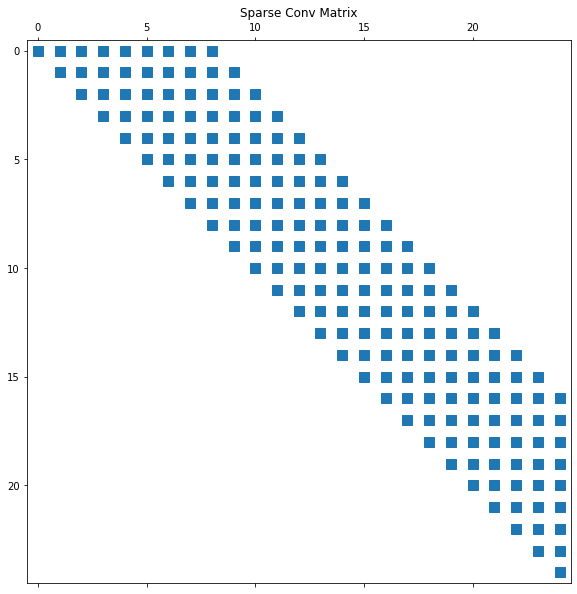

0.002372
0.000392


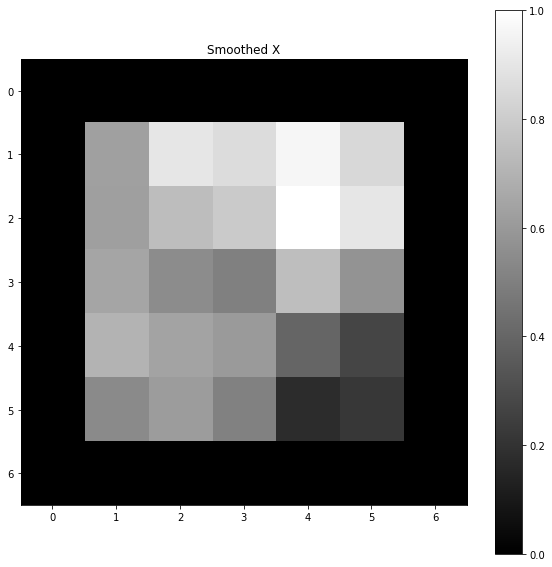

In [38]:
import numpy as np

def gkern(l=5, sig=1.):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# Convolution kernel
k_supp = 3
k_supp_half = (k_supp - 1) // 2 
gaussian = gkern(k_supp, 3.0)
# show_image(gaussian, "Gaussian")

# Sample image
l = 5
l_padded = l + k_supp - 1
x = color.rgb2gray(data.astronaut())
x = resize(x, (l, l), anti_aliasing=True)
# show_image(x, "X")

# scikit_convolved = normalise(convolve2d(x, gaussian, mode="same")) # use full to compare against the partially processed edges
# show_image(scikit_convolved, "Scikit Convolved")

# "Convolution" matrix
gaussian = gaussian.flatten()
offsets = np.arange(k_supp**2)
conv_m = dia_matrix.tocsr(diags(gaussian, offsets, shape=(l**2, l**2)))
show_sparse_image(conv_m, "Sparse Conv Matrix")
print((conv_m.data.nbytes + conv_m.indptr.nbytes + conv_m.indices.nbytes) / 10**6)

# pad x to accomodate convolution
x = np.pad(x, k_supp_half)
print((x.size * x.itemsize) / 10**6)
# x = x.reshape(1, l**2)
# x = conv_m @ x.T
# x = x.reshape(l, l)
        
show_image(normalise(x), "Smoothed X")
# show_image(np.absolute(scikit_convolved - normalise(x)), "Abs Diff")

# Ideal: might make sense to use a numba accelerated function which populates preallocated numpy arrays for row/col/element values
# then use those to create a coo(?) sparse matrix?